In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, Reshape, Dropout, Bidirectional, BatchNormalization, LSTM, Dense, Flatten, TimeDistributed, Bidirectional, Attention, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
input_shape=[200,200,3]
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, Reshape, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D, Concatenate


In [17]:
img_height, img_width = 224, 224  # Adjust as needed
batch_size = 32
num_channels = 3  # Assuming RGB images

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=to_grayscale_then_rgb,
    validation_split=0.30)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted\Dataset",
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted\Dataset", # same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 384 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


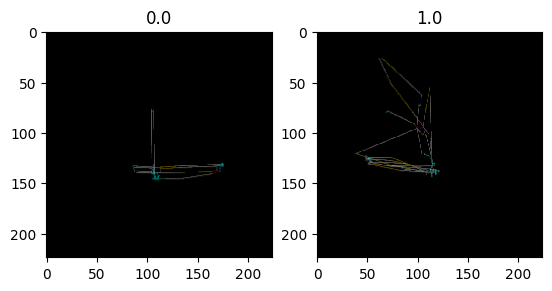

In [19]:
images, labels = train_generator.next()

fig, axes = plt.subplots(1, 2)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])
# show the figure
plt.show()

In [20]:
def attention_cnn_lstm(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    
    # 1st Convolutional Layer
    x = Conv2D(filters=126, kernel_size=(7, 7), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # 2nd Convolutional Layer
    x = Conv2D(filters=64, kernel_size=(7, 7), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Attention Layer
    attention = Attention()([x, x])
    x = GlobalAveragePooling2D()(attention)
    
    # Reshaping for LSTM
    x = tf.reshape(x, [-1, x.shape[1], x.shape[2] * x.shape[3]])
    
    # LSTM Layer
    x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
    
    # Dense Layer
    x = Dense(128, activation='relu')(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create the model
model = attention_cnn_lstm()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


IndexError: tuple index out of range

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 24, 1536), (None, 1, 1536)]

In [ ]:

# Train the model using the ImageDataGenerator
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator))


In [9]:
##Confusion Matrix Generator and ROC Curve
y_pred_real = model.predict(validation_generator)
y_pred = [int(p >= 0.5) for p in y_pred_real] ##With sigmoid 1 neuron
##y_pred = np.argmax(Y_pred, axis=1) ##With softmax and 2 neurons 
y_true = validation_generator.classes
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)

147/147 [==============================] - 1s 9ms/step
[[45 43]
 [23 36]]


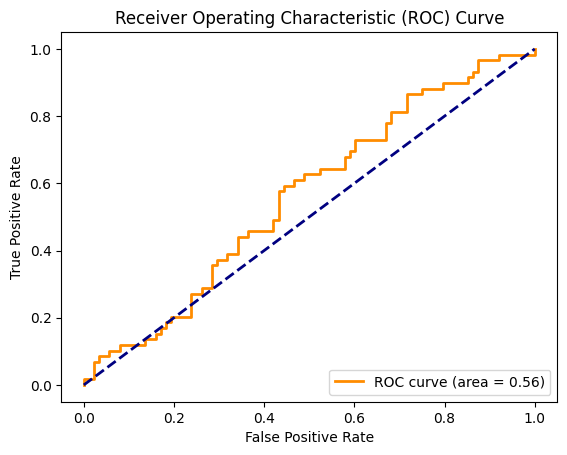

In [10]:
from sklearn.metrics import roc_curve, auc
# Calculate the ROC curve and AUC score, sklearn takes probabilities instead of classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred_real)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()